### Calculate hydro reservoir inflow based on ENTSO-E Transparency Platform data

In [1]:
import os.path

import pandas as pd
from numpy import floor

DATADIR = 'hydro_data'

Define [bidding zones](https://www.nordpoolgroup.com/maps/#/nordic) to be used.

In [1]:
ZONES = ['NO{}'.format(i) for i in range(1, 6)]
print(ZONES)

['NO1', 'NO2', 'NO3', 'NO4', 'NO5']


Define which [e-Highways](http://www.e-highway2050.eu/e-highway2050/) network nodes belong to which bidding zones. See image below. 
![](img/E-highway.png).

In [2]:
NODES_TO_BIDDING_ZONES = {
    '79NO': 'NO2',
    '80NO': 'NO1',
    '81NO': 'NO5',
    '82NO': 'NO1', 
    '83NO': 'NO3',
    '84NO': 'NO4',
    '85NO': 'NO4',
    }

Data was downloaded from ENTSO-E Transparency Plaftorm using 'Export data' --> CSV. First, process data for [Water Reservoirs and Hydro Storage Plants](https://transparency.entsoe.eu/generation/r2/waterReservoirsAndHydroStoragePlants/show):

In [3]:
series = list()  # Initialize a list for time series of different zones

for zone in ZONES:
    filename = f'Water Reservoirs and Hydro Storage Plants_201601040000-201801010000_{zone}.csv'
    df = pd.read_csv(os.path.join(DATADIR, filename))
    df['Week'] = df['Week'].str.extract('(\d+)').astype(int)
    df.set_index('Week', inplace=True)
    df.columns = df.columns.str.extract('(\d{4})', expand=False).astype(int)  # Extract year from column names
    df.columns.name = 'Year'
    
    ts = df.unstack().fillna(0)
    ts.name = zone
    
    series.append(ts)

# Combine as a single data frame
reslevel = pd.concat(series, axis=1).sort_index()

Calculate reservoir energy change between weeks and select only year 2017 data.

In [13]:
res_change = reslevel.diff(1).loc[2017]

Process data for [Actual Generation per Production Type](https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show) downloaded as CSV files.

In [5]:
# Initialize lists for data frames
ror_series = list()  # Run of River hydropower generation
res_series = list()  # Reservoir hydropower generation

for zone in ZONES:
    filename = f'Actual Generation per Production Type_201701010000-201801010000_{zone}.csv'
    ts = pd.read_csv(os.path.join(DATADIR, filename),
                     usecols=['MTU',
                              'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
                              'Hydro Water Reservoir  - Actual Aggregated [MW]'])
    ts['timestamp'] = pd.to_datetime(ts['MTU'].str.split(' - ', expand=True)[0])  # Use first part of time period as the timestamp
    ts.set_index('timestamp', inplace=True)
    ror_series.append(pd.Series(ts['Hydro Run-of-river and poundage  - Actual Aggregated [MW]'], 
                                name=zone))
    res_series.append(pd.Series(ts['Hydro Water Reservoir  - Actual Aggregated [MW]'], 
                                name=zone))
    
# Combine data
ror_production = pd.concat(ror_series, axis=1).sort_index()
res_production = pd.concat(res_series, axis=1).sort_index()

Calculate week number of each entry, limiting to 52 (week 53 will be 52).

In [6]:
res_production['Week'] = floor(res_production.index.dayofyear / 7).astype(int) + 1
res_production['Week'] = res_production['Week'].clip_upper(52)

Solve reservoir inflows from equation
     
    res_change = inflow - res_production

and limiting inflows to zero from below.

In [ ]:
weekly_inflow = (res_change + res_production.groupby('Week').sum()).clip_lower(0)

Resample weekly inflows to hourly values using linear interpolation. Note that weekly values have to be divided by 168 (hours in the week).

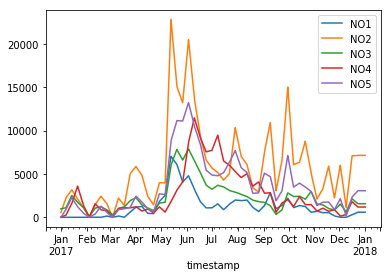

In [15]:
# Get timestamps for the beginning of each week
weekly_inflow['timestamp'] = res_production.reset_index().groupby('Week').first()['timestamp']
res_inflow = weekly_inflow.set_index('timestamp').reindex(res_production.index).interpolate() / 168

res_inflow.plot()

Scenario data for total annual reservoir and and run-of-river hydropower generation, respectively. These are used for dividing bidding zone data to nodes.

In [ ]:
HYDRORES_ENERGY = pd.Series({
    #NODE   SumOfHydroReservoir(GWhe)
    '79NO': 31711.536644905,
    '80NO': 21619.5529009666,
    '81NO': 32494.7734889343,
    '82NO': 15440.1619339486,
    '83NO': 9827.19268041268,
    '84NO': 17637.2102773001,
    '85NO': 1248.59707353264,
})

ROR_ENERGY = pd.Series({    
    #NODE   SumOfRoR(GWhe)
    '79NO': 15021.4952853046,
    '80NO': 10241.0052091998,
    '81NO': 15392.5081659272,
    '82NO': 7313.87829900999,
    '83NO': 4655.06071716234,
    '84NO': 8354.60211194832,
    '85NO': 591.450211427677,
})

In [8]:
ts_influx = pd.DataFrame(index=inflow.index)
for node, zone in NODES_TO_BIDDING_ZONES.items():
    _nodes = [n for n in NODES_TO_BIDDING_ZONES.keys()  # All nodes that overlap with the current bidding zone
              if NODES_TO_BIDDING_ZONES[n] == zone]
    # Divide zone data to nodes
    ts_influx[f'{node}_Reservoir'] = (HYDRORES_ENERGY[node] / HYDRORES_ENERGY[_nodes].sum()
                                      * inflow[zone])
    ts_influx[f'{node}_RoR'] = (ROR_ENERGY[node] / ROR_ENERGY[_nodes].sum()
                                * ror_production[zone])



In [ ]:
ts_influx.columns = pd.MultiIndex.from_product([['hydro'], ts_influx.columns])
ts_influx.index = pd.MultiIndex.from_product([['f00'], 
                                              [f't{t + 1:06d}' for t 
                                               in range(len(ts_influx.index))]])

In [9]:
ts_influx

hydro                                                     \
            79NO_Reservoir 79NO_RoR 80NO_Reservoir    80NO_RoR 81NO_Reservoir   
f00 t000001     558.315476    239.0       0.000000  366.940189       0.000000   
    t000002     570.050595    239.0       0.021389  358.189628       6.175761   
    t000003     581.785714    241.0       0.042779  356.439516      12.351521   
    t000004     593.520833    241.0       0.064168  357.606258      18.527282   
    t000005     605.255952    241.0       0.085557  355.856145      24.703042   
    t000006     616.991071    238.0       0.106946  358.189628      30.878803   
    t000007     628.726190    239.0       0.128336  361.689853      37.054563   
    t000008     640.461310    239.0       0.149725  360.523111      43.230324   
    t000009     652.196429    241.0       0.171114  361.106482      49.406085   
    t000010     663.931548    242.0       0.192504  365.773448      55.581845   
    t000011     675.666667    243.0       0.213893  360.523111      61.757606   
    t000012     687.401786    247.0       0.235282  361.106482      67.933366   
    t000013     699.136905    246.0       0.256672  361.689853      74.109127   
    t000014     710.872024    246.0       0.278061  361.689853      80.284888   
    t000015     722.607143    246.0       0.299450  364.606706      86.460648   
    t000016     734.342262    245.0       0.320839  360.523111      92.636409   
    t000017     746.077381    246.0       0.342229  363.439965      98.812169   
    t000018     757.812500    245.0       0.363618  361.689853     104.987930   
    t000019     769.547619    244.0       0.385007  363.439965     111.163690   
    t000020     781.282738    243.0       0.406397  362.856594     117.339451   
    t000021     793.017857    242.0       0.427786  365.773448     123.515212   
    t000022     804.752976    242.0       0.449175  362.273223     129.690972   
    t000023     816.488095    239.0       0.470565  364.606706     135.866733   
    t000024     828.223214    229.0       0.491954  358.189628     142.042493   
    t000025     839.958333    238.0       0.513343  423.527150     148.218254   
    t000026     851.693452    238.0       0.534732  424.693892     154.394015   
    t000027     863.428571    238.0       0.556122  425.860633     160.569775   
    t000028     875.163690    238.0       0.577511  421.193667     166.745536   
    t000029     886.898810    238.0       0.598900  421.777038     172.921296   
    t000030     898.633929    240.0       0.620290  431.694340     179.097057   
...                    ...      ...            ...         ...            ...   
    t008731    7137.196429    220.0     345.181850  407.776140    3065.452381   
    t008732    7137.196429    219.0     345.181850  404.859287    3065.452381   
    t008733    7137.196429    220.0     345.181850  405.442657    3065.452381   
    t008734    7137.196429    220.0     345.181850  404.859287    3065.452381   
    t008735    7137.196429    220.0     345.181850  407.192770    3065.452381   
    t008736    7137.196429    215.0     345.181850  399.025579    3065.452381   
    t008737    7137.196429    215.0     345.181850  400.775692    3065.452381   
    t008738    7137.196429    216.0     345.181850  403.109175    3065.452381   
    t008739    7137.196429    216.0     345.181850  401.942433    3065.452381   
    t008740    7137.196429    216.0     345.181850  401.942433    3065.452381   
    t008741    7137.196429    215.0     345.181850  399.608950    3065.452381   
    t008742    7137.196429    215.0     345.181850  404.859287    3065.452381   
    t008743    7137.196429    215.0     345.181850  413.026477    3065.452381   
    t008744    7137.196429    215.0     345.181850  414.776589    3065.452381   
    t008745    7137.196429    215.0     345.181850  415.943331    3065.452381   
    t008746    7137.196429    215.0     345.181850  419.443555    3065.452381   
    t008747    7137.196429    215.0     345.181850  